# King County Housing Investigation  
Explaining home pricing through regression models

## Overview<hr/>  
Sales data of homes in King County from June 2021-June2022 may provide valuable insights by investigating the houses' features.

This information may be able to aid in the home-buying process for homebuyers looking to gain an understanding of what to expect when searching in the area.

## Understandings:

### Applications:  
- Future King County residents want to make informed decisions when home shopping.
- There are many features that may be able to describe housing prices.

<br/>

### Data:  
- House sales data from June 2021 to June 2022 - King County Assessor's office (provided by Flatiron School)
    - Contains some data from nearby zip codes as well
    - [kc_house_data.csv](data/kc_house_data.csv)
        - a detailed breakdown of this data is available [here: column_names.md](data/column_names.md)
- Zip code data - [zip-codes.com](https://www.zip-codes.com/county/wa-king.asp)
    - Used to cross-reference King County zip codes
    - [King_County_Zip_Codes.csv](data/King_County_Zip_Codes.csv)
- Regional GIS data - [King County GIS, Open Data](https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?location=47.637170%2C-122.142755%2C10.98)
    - Used to find zip codes in a proximity
    - [zips_5_mile.csv](data/zips_5_mile.csv)

### Methodology
Because of the litany of features that can influence home pricing, this project investigates features and their effects through multiple linear regression in an attempt to best describe variations in housing prices.  
For our purposes, we'll be observing significance with a standard $\alpha$ of $\alpha=0.05$.

## Imports and Data

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import Rectangle

##### custom functions used to check presence of
#       features in numeric data and create money-
#       formatted y-axis labels
from code.features import has_feature, ytick_convert
#####

import numpy as np
from random import gauss, seed      # ! <= @Anat, do we use this?
from scipy import stats
import seaborn as sns
from mpl_toolkits import mplot3d    # ! is this used anywhere?
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
# ! @Anat, do we use all of these? Can we reduce it any?

### Dataframes and Defaults

In [3]:
housing_df = pd.read_csv('data/kc_house_data.csv')
zip_codes = pd.read_csv('data/King_County_Zip_Codes.csv')
nearby_zips_df = pd.read_csv('data/zips_5_mile.csv')

In [4]:
display(
    housing_df.info(),
    zip_codes.head()
    # nearby_zips_df isn't used until much later
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

None

,Zip Codes
0,98001
1,98002
2,98003
3,98004
4,98005


In [5]:
sns.set()

In [6]:
alpha = 0.05            # default confidence 
upper_cost = 5000000    # $5,000,000, maximum home value we want to investigate

## Feature Engineering

Here, we extract the zip code from the address values and cross reference them with known addresses that are in King County.

Additionally, we drop several columns that are unused to make the data easier to look at and understand.

In [7]:
housing_df['zip'] = housing_df['address'].map(lambda x: x.split(',')[-2][-5:])
housing_df.drop(columns=['address','lat','long', 'heat_source', 'grade', 'sewer_system', 'nuisance'], inplace = True)
kc_only = housing_df.merge(zip_codes['Zip Codes'].astype(str),left_on='zip',right_on='Zip Codes',how='inner')

In [8]:
display(kc_only.describe(), kc_only.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29189 entries, 0 to 29188
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29189 non-null  int64  
 1   date           29189 non-null  object 
 2   price          29189 non-null  float64
 3   bedrooms       29189 non-null  int64  
 4   bathrooms      29189 non-null  float64
 5   sqft_living    29189 non-null  int64  
 6   sqft_lot       29189 non-null  int64  
 7   floors         29189 non-null  float64
 8   waterfront     29189 non-null  object 
 9   greenbelt      29189 non-null  object 
 10  view           29189 non-null  object 
 11  condition      29189 non-null  object 
 12  sqft_above     29189 non-null  int64  
 13  sqft_basement  29189 non-null  int64  
 14  sqft_garage    29189 non-null  int64  
 15  sqft_patio     29189 non-null  int64  
 16  yr_built       29189 non-null  int64  
 17  yr_renovated   29189 non-null  int64  
 18  zip   

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated
count,2.918900e+04,2.918900e+04,29189.000000,29189.000000,29189.000000,2.918900e+04,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000
mean,4.535750e+09,1.113059e+06,3.435335,2.331889,2130.911987,1.720745e+04,1.516564,1825.949844,480.890747,336.257666,216.342972,1973.827401,93.931344
std,2.882323e+09,8.957550e+05,0.978759,0.896124,977.502626,6.131060e+04,0.548233,880.928042,586.056457,286.283099,246.810496,31.681435,422.974700
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000
25%,2.085201e+09,6.450000e+05,3.000000,2.000000,1440.000000,5.000000e+03,1.000000,1190.000000,0.000000,0.000000,40.000000,1952.000000,0.000000
50%,3.874000e+09,8.685000e+05,3.000000,2.500000,1940.000000,7.560000e+03,1.500000,1580.000000,0.000000,400.000000,140.000000,1976.000000,0.000000
75%,7.287100e+09,1.310000e+06,4.000000,3.000000,2640.000000,1.078400e+04,2.000000,2290.000000,960.000000,510.000000,310.000000,2001.000000,0.000000
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000


None

We create new columns that relate to whether or not a home has a basement, garage, or patio by checking whether or not any square footage was listed. We then drop the old columns.

We do a similar process with renovation year.

In [9]:
new_columns = ['has_basement', 'has_garage', 'has_patio', 'is_renovated']
check_columns = ['sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_renovated']
kc_only[new_columns] = kc_only[check_columns].apply(has_feature)
kc_only['sell_year'] = kc_only['date'].map(lambda x: x.split('/')[-1][-4:])
kc_only['sell_age'] = kc_only['sell_year'].astype(int) - kc_only['yr_built'].astype(int)
kc_only.drop(columns=check_columns, inplace=True)
kc_only.drop('sqft_above', axis = 1, inplace=True)
kc_only.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,condition,yr_built,zip,Zip Codes,has_basement,has_garage,has_patio,is_renovated,sell_year,sell_age
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,Good,1969,98055,98055,0,0,1,0,2022,53
1,3340401570,3/2/2022,750000.0,3,2.0,1830,7969,1.0,NO,NO,...,Average,1950,98055,98055,1,1,1,1,2022,72
2,7399301200,3/29/2022,728000.0,4,2.0,2170,7520,1.0,NO,NO,...,Average,1973,98055,98055,1,1,1,0,2022,49
3,9899200050,3/24/2022,565000.0,4,2.0,1400,10364,1.5,NO,NO,...,Good,1971,98055,98055,0,1,1,0,2022,51
4,6673070070,12/28/2021,645000.0,3,2.0,1520,8250,1.0,NO,NO,...,Average,1981,98055,98055,1,1,1,0,2021,40


Houses are nice, but we want to investigate **HOMES**.

We'll narrow down our scope to houses that are larger than 400sqft.<sup>[1](https://www.seattle.gov/documents/Departments/SDCI/Codes/SeattleResidentialCode/2018SRCAppendixQ.pdf)</sup>

We also are only interested in homes that meet the following criteria:
1. Must have **AT LEAST** 1 bedroom
2. Must have **AT LEAST** 1 bathroom
3. Must be worth less than $5,000,000 US.





<sub>[[1]](https://www.seattle.gov/documents/Departments/SDCI/Codes/SeattleResidentialCode/2018SRCAppendixQ.pdf)
: houses less than 400sqft are defined as _tiny homes_ per [Seattle residential code](
https://www.seattle.gov/documents/Departments/SDCI/Codes/SeattleResidentialCode/2018SRCAppendixQ.pdf)
</sub>

In [10]:
homes_df = kc_only[(kc_only['sqft_living'] > 400) &
    (kc_only['bedrooms'] > 0) &
    (kc_only['bathrooms'] > 0) &
    (kc_only['price'] < upper_cost)                        # <= dropping houses valued at and over $5,000,000 - most demographics will not be looking for this.
    ]

### Adding Condition Variable
Transforming condition into numeric variable 0-4. We are ordinarly encoding this to make it a numeric variable from a category to a numeric and keeping the natural ordering system of: 
- Poor = 0
- Fair = 1
- Average = 2
- Good = 3
- Very Good = 4

In [11]:
homes_df['condition'].value_counts() #checking out what is in the condition column 

Average      17405
Good          7996
Very Good     3238
Fair           222
Poor            58
Name: condition, dtype: int64

In [12]:
#creating its own dataframe for simplicity 
condition_df = pd.DataFrame(homes_df['condition'])
condition_df 

,condition
0,Good
1,Average
2,Average
3,Good
4,Average
...,...
29184,Very Good
29185,Average
29186,Fair
29187,Average


In [13]:
categories = [['Poor', 'Fair', 'Average', 'Good', 'Very Good']]
ords = OrdinalEncoder(categories=categories)
ords.fit(condition_df)
condition_df['condition'] = ords.transform(condition_df)
condition_df

,condition
0,3.0
1,2.0
2,2.0
3,3.0
4,2.0
...,...
29184,4.0
29185,2.0
29186,1.0
29187,2.0


In [14]:
homes_df['condition_numeric'] = condition_df['condition']
homes_df.head() #checking out new column

<ipython-input-14-3970a1d45664>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homes_df['condition_numeric'] = condition_df['condition']


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,yr_built,zip,Zip Codes,has_basement,has_garage,has_patio,is_renovated,sell_year,sell_age,condition_numeric
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,1969,98055,98055,0,0,1,0,2022,53,3.0
1,3340401570,3/2/2022,750000.0,3,2.0,1830,7969,1.0,NO,NO,...,1950,98055,98055,1,1,1,1,2022,72,2.0
2,7399301200,3/29/2022,728000.0,4,2.0,2170,7520,1.0,NO,NO,...,1973,98055,98055,1,1,1,0,2022,49,2.0
3,9899200050,3/24/2022,565000.0,4,2.0,1400,10364,1.5,NO,NO,...,1971,98055,98055,0,1,1,0,2022,51,3.0
4,6673070070,12/28/2021,645000.0,3,2.0,1520,8250,1.0,NO,NO,...,1981,98055,98055,1,1,1,0,2021,40,2.0


In [15]:
homes_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28919 entries, 0 to 29188
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 28919 non-null  int64  
 1   date               28919 non-null  object 
 2   price              28919 non-null  float64
 3   bedrooms           28919 non-null  int64  
 4   bathrooms          28919 non-null  float64
 5   sqft_living        28919 non-null  int64  
 6   sqft_lot           28919 non-null  int64  
 7   floors             28919 non-null  float64
 8   waterfront         28919 non-null  object 
 9   greenbelt          28919 non-null  object 
 10  view               28919 non-null  object 
 11  condition          28919 non-null  object 
 12  yr_built           28919 non-null  int64  
 13  zip                28919 non-null  object 
 14  Zip Codes          28919 non-null  object 
 15  has_basement       28919 non-null  int64  
 16  has_garage         289

We were able to find a few zip codes that only
have a handful of homes sold. Because this is 
likely to be difficult to model off of, we'll
limit the dataframe only to zip codes that have
at least 100 sales during the year we looked at.

In [16]:
homes_df.value_counts('zip')

zip
98042    991
98038    857
98103    758
98115    754
98117    743
        ... 
98051     67
98039     35
98288     18
98224      4
98050      2
Length: 76, dtype: int64

In [17]:
# create a df of zips and their counts and merge the counts with the homes_df
zip_counts = homes_df['zip'].value_counts().rename('zip_counts')
zips_counted = homes_df.merge(
    zip_counts,
    left_on='zip',
    right_index=True
)

# get zip codes that have at least 100 entries
homes_df = zips_counted[zips_counted['zip_counts'] >= 100]
homes_df


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,zip,Zip Codes,has_basement,has_garage,has_patio,is_renovated,sell_year,sell_age,condition_numeric,zip_counts
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,98055,98055,0,0,1,0,2022,53,3.0,219
1,3340401570,3/2/2022,750000.0,3,2.0,1830,7969,1.0,NO,NO,...,98055,98055,1,1,1,1,2022,72,2.0,219
2,7399301200,3/29/2022,728000.0,4,2.0,2170,7520,1.0,NO,NO,...,98055,98055,1,1,1,0,2022,49,2.0,219
3,9899200050,3/24/2022,565000.0,4,2.0,1400,10364,1.5,NO,NO,...,98055,98055,0,1,1,0,2022,51,3.0,219
4,6673070070,12/28/2021,645000.0,3,2.0,1520,8250,1.0,NO,NO,...,98055,98055,1,1,1,0,2021,40,2.0,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29092,723039050,12/16/2021,1826000.0,2,3.0,2070,71264,2.0,NO,NO,...,98070,98070,1,1,1,0,2021,20,2.0,193
29093,2022039037,4/14/2022,256000.0,2,1.0,1330,113815,1.0,NO,NO,...,98070,98070,0,1,0,1,2022,111,3.0,193
29094,2322039033,7/14/2021,950000.0,2,2.5,1960,11406,2.0,NO,NO,...,98070,98070,1,1,1,1,2021,83,2.0,193
29095,3023039221,9/21/2021,450000.0,2,2.0,840,138520,1.0,NO,NO,...,98070,98070,0,0,1,0,2021,1,2.0,193


In [18]:
numeric_columns =[
    'price', 'bedrooms', 'bathrooms',
    'sqft_living', 'sqft_lot', 'floors',
    'has_patio', 'has_garage', 'has_basement',
    'sell_age','is_renovated', 'condition_numeric']
numeric_homes = homes_df[numeric_columns]   
numeric_homes

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,has_patio,has_garage,has_basement,sell_age,is_renovated,condition_numeric
0,675000.0,4,1.0,1180,7140,1.0,1,0,0,53,0,3.0
1,750000.0,3,2.0,1830,7969,1.0,1,1,1,72,1,2.0
2,728000.0,4,2.0,2170,7520,1.0,1,1,1,49,0,2.0
3,565000.0,4,2.0,1400,10364,1.5,1,1,0,51,0,3.0
4,645000.0,3,2.0,1520,8250,1.0,1,1,1,40,0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29092,1826000.0,2,3.0,2070,71264,2.0,1,1,1,20,0,2.0
29093,256000.0,2,1.0,1330,113815,1.0,0,1,0,111,1,3.0
29094,950000.0,2,2.5,1960,11406,2.0,1,1,1,83,1,2.0
29095,450000.0,2,2.0,840,138520,1.0,1,0,0,1,0,2.0


In [19]:
homes_df.corr() ##looking for most correlated variable to our y which is price

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,has_basement,has_garage,has_patio,is_renovated,sell_age,condition_numeric,zip_counts
id,1.000000,-0.033379,-0.004443,-0.010008,-0.025856,-0.119117,0.036063,0.023791,0.005129,0.034086,0.003626,-0.028559,-0.023901,-0.008970,-0.005306
price,-0.033379,1.000000,0.346636,0.521572,0.655957,0.093478,0.245874,0.122039,0.110291,0.140445,0.178622,0.082413,-0.120565,-0.004978,-0.187508
bedrooms,-0.004443,0.346636,1.000000,0.586966,0.637821,-0.001560,0.196012,0.180781,0.076442,0.221578,0.167883,0.009487,-0.181161,0.016930,-0.017833
bathrooms,-0.010008,0.521572,0.586966,1.000000,0.771528,0.035678,0.434804,0.462116,0.117240,0.340784,0.288181,0.038496,-0.462584,-0.067488,-0.044752
sqft_living,-0.025856,0.655957,0.637821,0.771528,1.000000,0.119295,0.360376,0.333144,0.092037,0.296886,0.278443,0.030607,-0.333493,-0.071212,-0.086157
sqft_lot,-0.119117,0.093478,-0.001560,0.035678,0.119295,1.000000,-0.021773,0.011513,-0.043234,-0.016584,0.029224,0.009004,-0.011624,-0.004401,-0.045787
floors,0.036063,0.245874,0.196012,0.434804,0.360376,-0.021773,1.000000,0.522162,-0.194081,0.140938,0.204496,-0.015231,-0.522192,-0.268241,0.006743
yr_built,0.023791,0.122039,0.180781,0.462116,0.333144,0.011513,0.522162,1.000000,-0.280036,0.490602,0.191227,-0.236940,-0.999885,-0.304623,0.082303
has_basement,0.005129,0.110291,0.076442,0.117240,0.092037,-0.043234,-0.194081,-0.280036,1.000000,-0.099942,0.083968,0.057041,0.279794,0.067167,-0.064539
has_garage,0.034086,0.140445,0.221578,0.340784,0.296886,-0.016584,0.140938,0.490602,-0.099942,1.000000,0.118680,-0.123185,-0.490574,-0.080984,0.080023


Here, we create a heatmap focused specifically on variables' effects on price

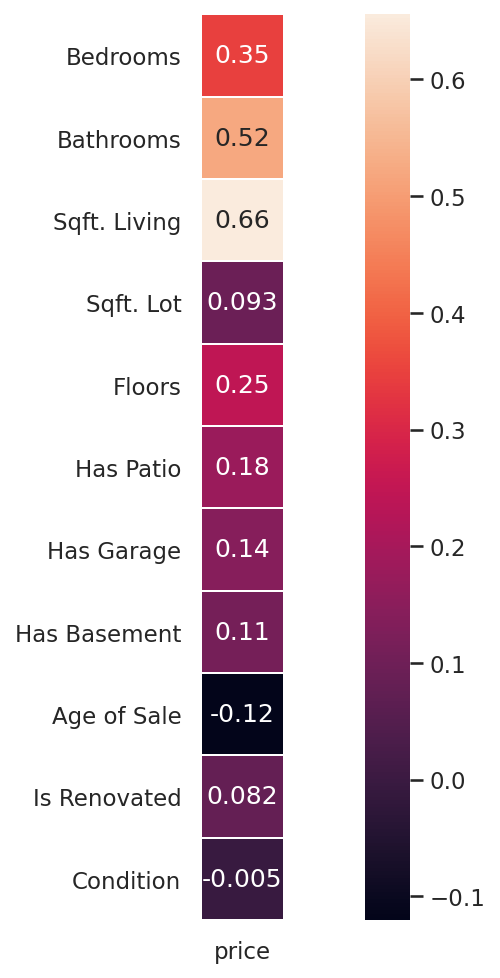

<Figure size 1440x720 with 0 Axes>

In [20]:
#heatmaps with correlation

fig, ax = plt.subplots(figsize=(14,8),dpi=150)

plt.figure(figsize = (20,10))
sns.heatmap(
    numeric_homes.corr()[1:][['price']],
    annot=True,
    linewidths=.5,
    square=True,
    ax=ax
    )
ax.set(
    yticklabels=[
        'Bedrooms','Bathrooms',
        'Sqft. Living','Sqft. Lot',
        'Floors','Has Patio',
        'Has Garage','Has Basement',
        'Age of Sale','Is Renovated',
        'Condition'
    ]
)
'';


## Simple Models

### Running simple regression based on most correlated variable of sqft_living

In [21]:
#run a simple regression on this correlation
x = homes_df['sqft_living']
y = homes_df['price']
simple_model = sm.OLS(y, sm.add_constant(x)).fit()
sm_summary = simple_model.summary()
sm_summary #shows a low rquared at .430 but model is significant. for every 1 sqft change, price increases by 568

#note kurtosis is 8, no need ot log Y 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                 2.162e+04
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:54:55   Log-Likelihood:            -4.1602e+05
No. Observations:               28622   AIC:                         8.320e+05
Df Residuals:                   28620   BIC:                         8.321e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        8.948e+04   7284.756     12.283      0.000    7.52e+04    1.04e+05
sqft_living   463.5104      3.153    147.021      0.000     457.331     469.690
==============================================================================
Omnibus:                     8359.493   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            42814.144
Skew:                           1.321   Prob(JB):                         0.00
Kurtosis:                       8.378   Cond. No.                     5.73e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

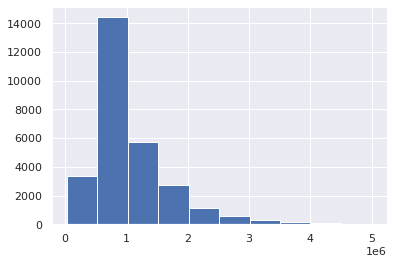

In [22]:
y.hist() #looking at skew. almost normal distbution, will not log Y. 
'';

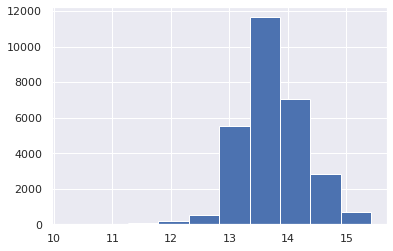

In [23]:
np.log(y).hist() #looking at skew. almost normal distbution, will not log Y. 
'';

In [24]:
#looking at model of all numeric variables within dataset
x2 = numeric_homes.drop(['price'], axis = 1)
model = sm.OLS(y, sm.add_constant(x2)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     2234.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:54:56   Log-Likelihood:            -4.1520e+05
No. Observations:               28622   AIC:                         8.304e+05
Df Residuals:                   28610   BIC:                         8.305e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.678e+05   2.09e+04     -8.040      0.000   -2.09e+05   -1.27e+05
bedrooms          -1.006e+05   3991.630    -25.201      0.000   -1.08e+05   -9.28e+04
bathrooms          9.612e+04   5980.791     16.071      0.000    8.44e+04    1.08e+05
sqft_living         480.4613      5.301     90.630      0.000     470.070     490.852
sqft_lot              0.1271      0.049      2.615      0.009       0.032       0.222
floors              8.09e+04   6680.872     12.109      0.000    6.78e+04     9.4e+04
has_patio         -1.262e+04   7234.404     -1.745      0.081   -2.68e+04    1556.393
has_garage         3547.3449   7290.221      0.487      0.627   -1.07e+04    1.78e+04
has_basement       1.547e+04   6367.936      2.429      0.015    2987.278     2.8e+04
sell_age           3242.8840    140.226     23.126      0.000    2968.034    3517.734
is_renovated       7.598e+04   1.46e+04      5.208      0.000    4.74e+04    1.05e+05
condition_numeric  2.453e+04   4401.611      5.573      0.000    1.59e+04    3.32e+04
==============================================================================
Omnibus:                     8313.881   Durbin-Watson:                   1.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46065.664
Skew:                           1.288   Prob(JB):                         0.00
Kurtosis:                       8.656   Cond. No.                     4.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Note that the has garage, has_patio are  both are statistically insignificant and will remove the two and rerun. 
sqft lot almost insignificant but will remain in model. Skew went down. 

In [25]:
pd.options.display.float_format = '{:20,.2f}'.format

x3 = numeric_homes.drop(['price', 'has_garage', 'has_patio'], axis = 1)
log_model2 = sm.OLS(y, sm.add_constant(x3)).fit()
log_model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                   OLS                   Adj. R-squared:          0.462      
Dependent Variable:      price                 AIC:                     830419.8163
Date:                    2023-03-30 23:54      BIC:                     830502.4357
No. Observations:        28622                 Log-Likelihood:          -4.1520e+05
Df Model:                9                     F-statistic:             2730.      
Df Residuals:            28612                 Prob (F-statistic):      0.00       
R-squared:               0.462                 Scale:                   2.3319e+11 
-----------------------------------------------------------------------------------
                     Coef.      Std.Err.     t     P>|t|     [0.025       0.975]   
-----------------------------------------------------------------------------------
const             -169666.1478 19399.7616  -8.7458 0.0000 -207690.5903 -131641.7052
bedrooms          -100381.4501  3987.4370 -25.1744 0.0000 -108197.0135  -92565.8866
bathrooms           95776.9088  5965.4526  16.0553 0.0000   84084.3418  107469.4757
sqft_living           479.8268     5.2621  91.1852 0.0000     469.5128     490.1408
sqft_lot                0.1246     0.0485   2.5687 0.0102       0.0295       0.2197
floors              79334.8897  6524.9633  12.1587 0.0000   66545.6556   92124.1239
has_basement        14250.8311  6332.3961   2.2505 0.0244    1839.0377   26662.6245
sell_age             3234.6330   128.1919  25.2327 0.0000    2983.3709    3485.8951
is_renovated        74774.5469 14574.2708   5.1306 0.0000   46208.2927  103340.8012
condition_numeric   24260.8330  4394.2481   5.5210 0.0000   15647.9007   32873.7654
-----------------------------------------------------------------------------------
Omnibus:                   8315.260           Durbin-Watson:              1.161    
Prob(Omnibus):             0.000              Jarque-Bera (JB):           46042.059
Skew:                      1.288              Prob(JB):                   0.000    
Kurtosis:                  8.654              Condition No.:              436069   
===================================================================================
* The condition number is large (4e+05). This might indicate             strong
multicollinearity or other numerical problems.
"""

In [26]:
x4 = numeric_homes[['bedrooms','bathrooms','sqft_living','condition_numeric']]
multi_model = sm.OLS(y, sm.add_constant(x4)).fit()
mm_summary = multi_model.summary2()
print(mm_summary)

                         Results: Ordinary least squares
Model:                   OLS                  Adj. R-squared:         0.443      
Dependent Variable:      price                AIC:                    831379.4820
Date:                    2023-03-30 23:54     BIC:                    831420.7917
No. Observations:        28622                Log-Likelihood:         -4.1568e+05
Df Model:                4                    F-statistic:            5700.      
Df Residuals:            28617                Prob (F-statistic):     0.00       
R-squared:               0.443                Scale:                  2.4118e+11 
---------------------------------------------------------------------------------
                     Coef.     Std.Err.     t     P>|t|     [0.025       0.975]  
---------------------------------------------------------------------------------
const             113445.2307 15067.4079   7.5292 0.0000   83912.4047 142978.0567
bedrooms          -94263.8141  4004.3793 

Note: SQFT lot no longer statistically significant. 

In [27]:
x5 = numeric_homes[['is_renovated', 'sell_age','sqft_living']]
multi_model = sm.OLS(y, sm.add_constant(x5)).fit()
mm_summary = multi_model.summary()
mm_summary #this is a lower adj R, but conditioning number is much lower since less variables. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                     7570.
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:54:56   Log-Likelihood:            -4.1571e+05
No. Observations:               28622   AIC:                         8.314e+05
Df Residuals:                   28618   BIC:                         8.315e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.295e+04   1.01e+04     -6.219      0.000   -8.28e+04   -4.31e+04
is_renovated  1.183e+05   1.44e+04      8.232      0.000    9.02e+04    1.47e+05
sell_age      2076.7867    100.746     20.614      0.000    1879.319    2274.254
sqft_living    486.2634      3.332    145.926      0.000     479.732     492.795
==============================================================================
Omnibus:                     8222.312   Durbin-Watson:                   1.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43449.196
Skew:                           1.287   Prob(JB):                         0.00
Kurtosis:                       8.459   Cond. No.                     1.15e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Multi regression model using zip codes 

Create an OLS model that describes the zip code's ability to describe price. Output this as a dataframe object that can be called and indexed into.

In [28]:
# get zip codes by median price in said zip code and sort high to low
zip_by_price_median = homes_df[
    ['zip', 'price']].groupby(by='zip').agg(
        {'price': 'median', 'zip': 'size'}
).rename(
    columns={'zip': 'count'}
).reset_index()
zip_by_price_median.sort_values('price', ascending=False, inplace=True)
zip_by_price_median

,zip,price,count
3,98004,"2,672,500.00",258
24,98040,"2,300,000.00",323
4,98005,"1,956,000.00",178
21,98033,"1,832,687.50",600
38,98075,"1,830,500.00",410
...,...,...,...
12,98022,"567,230.00",454
2,98003,"550,000.00",439
20,98032,"549,950.00",183
63,98168,"540,000.00",383


In [29]:
dummy_zips = pd.get_dummies(homes_df['zip']).drop(
        zip_by_price_median.iloc[0]['zip'],         # <= select the highest-(median) priced zip to drop it
        axis=1
    )

In [30]:
# investigate the effect of zip code by itself

X = sm.add_constant(dummy_zips)

zip_only_model = sm.OLS(np.log(y), X).fit().summary2()
print(zip_by_price_median.iloc[0],zip_only_model)

zip                    98004
price           2,672,500.00
count                    258
Name: 3, dtype: object                   Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.441     
Dependent Variable: price            AIC:                31336.0286
Date:               2023-03-30 23:54 BIC:                31906.1018
No. Observations:   28622            Log-Likelihood:     -15599.   
Df Model:           68               F-statistic:        332.9     
Df Residuals:       28553            Prob (F-statistic): 0.00      
R-squared:          0.442            Scale:              0.17456   
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      14.7461     0.0260   566.9025   0.0000   14.6951   14.7971
98001      -1.4719     0.0309   -47.5856   0.0000   -1.5326   -1.4113
98002      -1.

In [31]:
homes_df.info() , dummy_zips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28622 entries, 0 to 29096
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 28622 non-null  int64  
 1   date               28622 non-null  object 
 2   price              28622 non-null  float64
 3   bedrooms           28622 non-null  int64  
 4   bathrooms          28622 non-null  float64
 5   sqft_living        28622 non-null  int64  
 6   sqft_lot           28622 non-null  int64  
 7   floors             28622 non-null  float64
 8   waterfront         28622 non-null  object 
 9   greenbelt          28622 non-null  object 
 10  view               28622 non-null  object 
 11  condition          28622 non-null  object 
 12  yr_built           28622 non-null  int64  
 13  zip                28622 non-null  object 
 14  Zip Codes          28622 non-null  object 
 15  has_basement       28622 non-null  int64  
 16  has_garage         286

(None, None)

In [32]:
zip_homes = pd.concat([numeric_homes['sqft_living'] , dummy_zips], axis=1)
X = sm.add_constant(zip_homes)

zip_model = sm.OLS(y, X).fit()
print(zip_model.summary2())

                        Results: Ordinary least squares
Model:                  OLS                  Adj. R-squared:         0.691      
Dependent Variable:     price                AIC:                    814610.9804
Date:                   2023-03-30 23:54     BIC:                    815189.3156
No. Observations:       28622                Log-Likelihood:         -4.0724e+05
Df Model:               69                   F-statistic:            928.0      
Df Residuals:           28552                Prob (F-statistic):     0.00       
R-squared:              0.692                Scale:                  1.3394e+11 
--------------------------------------------------------------------------------
                Coef.      Std.Err.     t     P>|t|      [0.025        0.975]   
--------------------------------------------------------------------------------
const        1616842.6166 24039.3525  67.2582 0.0000  1569724.3542  1663960.8791
sqft_living      388.7704     2.5551 152.1531 0.0000 

Create two graphs, one that displays the value of prices by zip code and one that displays the number of homes in that zip code

''

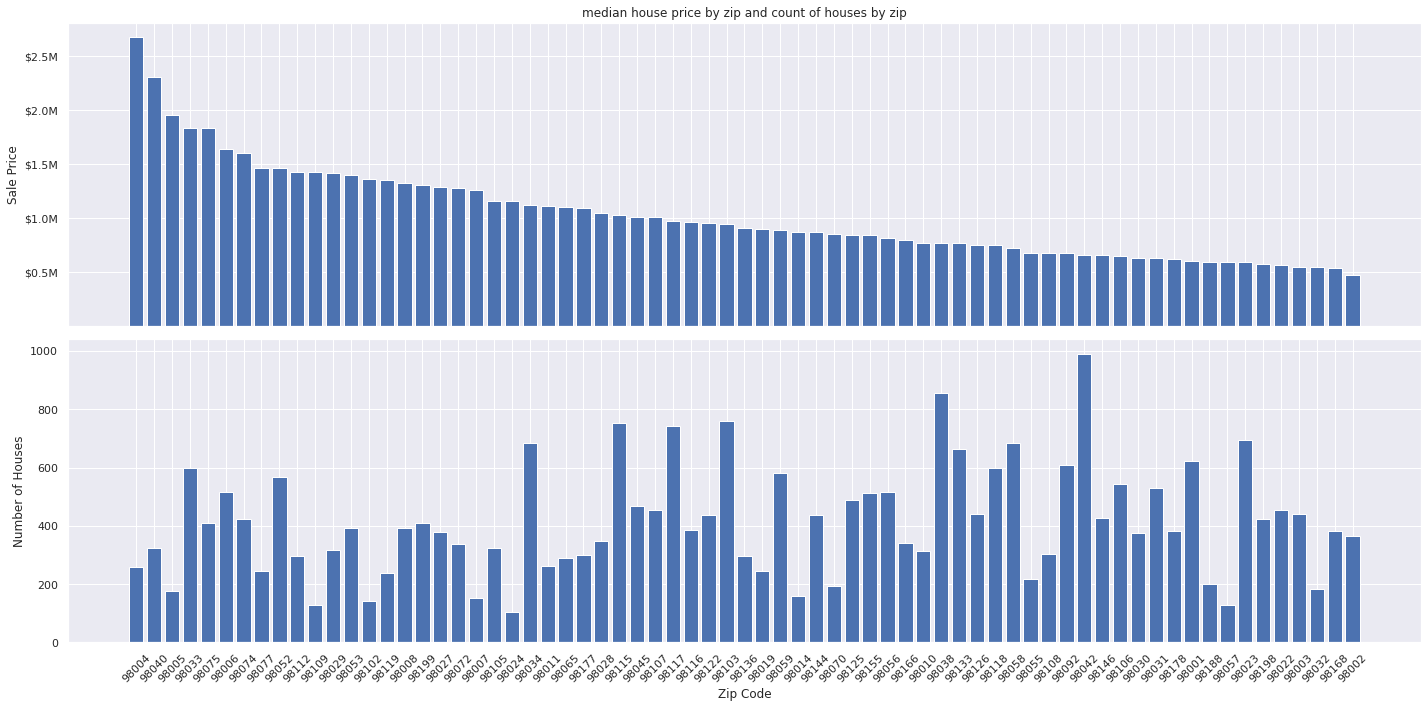

In [33]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 10))

y = [zip_by_price_median['price'], zip_by_price_median['count']]
x = zip_by_price_median['zip']

ax[0].bar(x=x, height=y[0])
ax[1].bar(x=x, height=y[1])

ticks, ticklabels = ytick_convert(5,500000,'M')
ax[0].set(
    title='median house price by zip and count of houses by zip',
    ylabel='Sale Price',
    yticks=ticks,
    yticklabels=ticklabels
)
ax[1].set(
    ylabel='Number of Houses',
    xlabel='Zip Code',
)

plt.xticks(rotation=45)
plt.tight_layout()
''

The model above shows a heavy relationship between zip codes and home prices

### 98004:
The zip code with the highest-median home price is zip 98004 in Bellevue.

![Image of King County by Zip code centered on Bellevue (98004)](./img/kc_counties_98004.png)  
<sup>source: [
    King County GIS - Open Data
    ](
        'https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?location=47.613041%2C-122.082727%2C10.98')</sup>

### Where we'll focus:

Because home prices can be so indicative of what amenities are available,
we'll be focusing on housing prices within 5 miles of the 98004 zip code,
looking specifically for the zip codes with the strongest negative
correlation in price to get an idea of what zip codes will yeald the
highest value at the lowest cost.

![Image of King County by Zip code centered on Bellevue (98004)](./img/kc_counties_98004_prox.png)

<sup>source: [
    King County GIS - Open Data
    ](
        'https://gis-kingcounty.opendata.arcgis.com/datasets/kingcounty::zipcodes-for-king-county-and-surrounding-area-zipcode-area/explore?location=47.613041%2C-122.082727%2C10.98')</sup>

We'll go ahead and display the dataframe of nearby zips that was imported earlier here.

In [34]:
nearby_zips_df

,ZIP,ZIPCODE,PREFERRED_CITY
0,"98,004",98004,BELLEVUE
1,"98,005",98005,BELLEVUE
2,"98,006",98006,BELLEVUE
3,"98,007",98007,BELLEVUE
4,"98,008",98008,BELLEVUE
5,"98,033",98033,KIRKLAND
6,"98,034",98034,KIRKLAND
7,"98,039",98039,MEDINA
8,"98,040",98040,MERCER ISLAND
9,"98,052",98052,REDMOND


In [35]:
nearby_zips_df['ZIPCODE'] = nearby_zips_df['ZIPCODE'].astype(str)
nearby_homes_df = homes_df.merge(nearby_zips_df,how='inner',left_on='zip',right_on='ZIPCODE').drop(
    columns=['ZIP','ZIPCODE','PREFERRED_CITY']      #<= dropping columns from nearby_zips_df, they're redundant
    )
nearby_homes_df


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,zip,Zip Codes,has_basement,has_garage,has_patio,is_renovated,sell_year,sell_age,condition_numeric,zip_counts
0,1604601802,12/14/2021,"775,000.00",3,3.00,2160,1400,2.00,NO,NO,...,98118,98118,1,1,1,0,2021,11,2.00,600
1,4006000502,10/27/2021,"700,000.00",6,3.50,1810,8519,1.00,NO,NO,...,98118,98118,1,1,1,0,2021,56,3.00,600
2,5249802390,3/3/2022,"274,380.00",2,1.00,1440,4000,1.00,NO,NO,...,98118,98118,1,0,1,1,2022,102,2.00,600
3,1105000058,10/28/2021,"599,000.00",4,2.00,1510,5013,1.50,NO,NO,...,98118,98118,0,0,1,1,2021,116,2.00,600
4,1704900215,5/12/2022,"1,100,000.00",3,2.00,1740,4883,1.00,NO,NO,...,98118,98118,1,0,1,1,2022,99,2.00,600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8103,9550204160,6/30/2021,"835,000.00",4,2.00,2280,3640,1.50,NO,NO,...,98105,98105,1,1,0,0,2021,92,2.00,323
8104,3131200640,6/24/2021,"1,250,000.00",3,2.00,1830,4590,2.00,NO,NO,...,98105,98105,1,0,1,0,2021,113,3.00,323
8105,3179100575,10/13/2021,"1,190,000.00",3,2.00,2060,6469,1.00,NO,NO,...,98105,98105,1,1,1,0,2021,71,4.00,323
8106,2862100450,6/24/2021,"1,160,000.00",5,3.00,1740,4400,1.00,NO,NO,...,98105,98105,1,1,1,0,2021,103,4.00,323


In [36]:
# same as zip by price median but only for nearby zips

nearby_zip_by_price_median = nearby_homes_df[
    ['zip', 'price']].groupby(by='zip').agg(
        {'price': 'median', 'zip': 'size'}
).rename(
    columns={'zip': 'count'}
).reset_index()
nearby_zip_by_price_median.sort_values('price', ascending=False, inplace=True)
nearby_zip_by_price_median

,zip,price,count
0,98004,"2,672,500.00",258
7,98040,"2,300,000.00",323
1,98005,"1,956,000.00",178
5,98033,"1,832,687.50",600
2,98006,"1,638,000.00",517
8,98052,"1,460,000.00",567
12,98112,"1,427,500.00",296
4,98008,"1,320,000.00",394
3,98007,"1,260,000.00",154
11,98105,"1,160,000.00",323


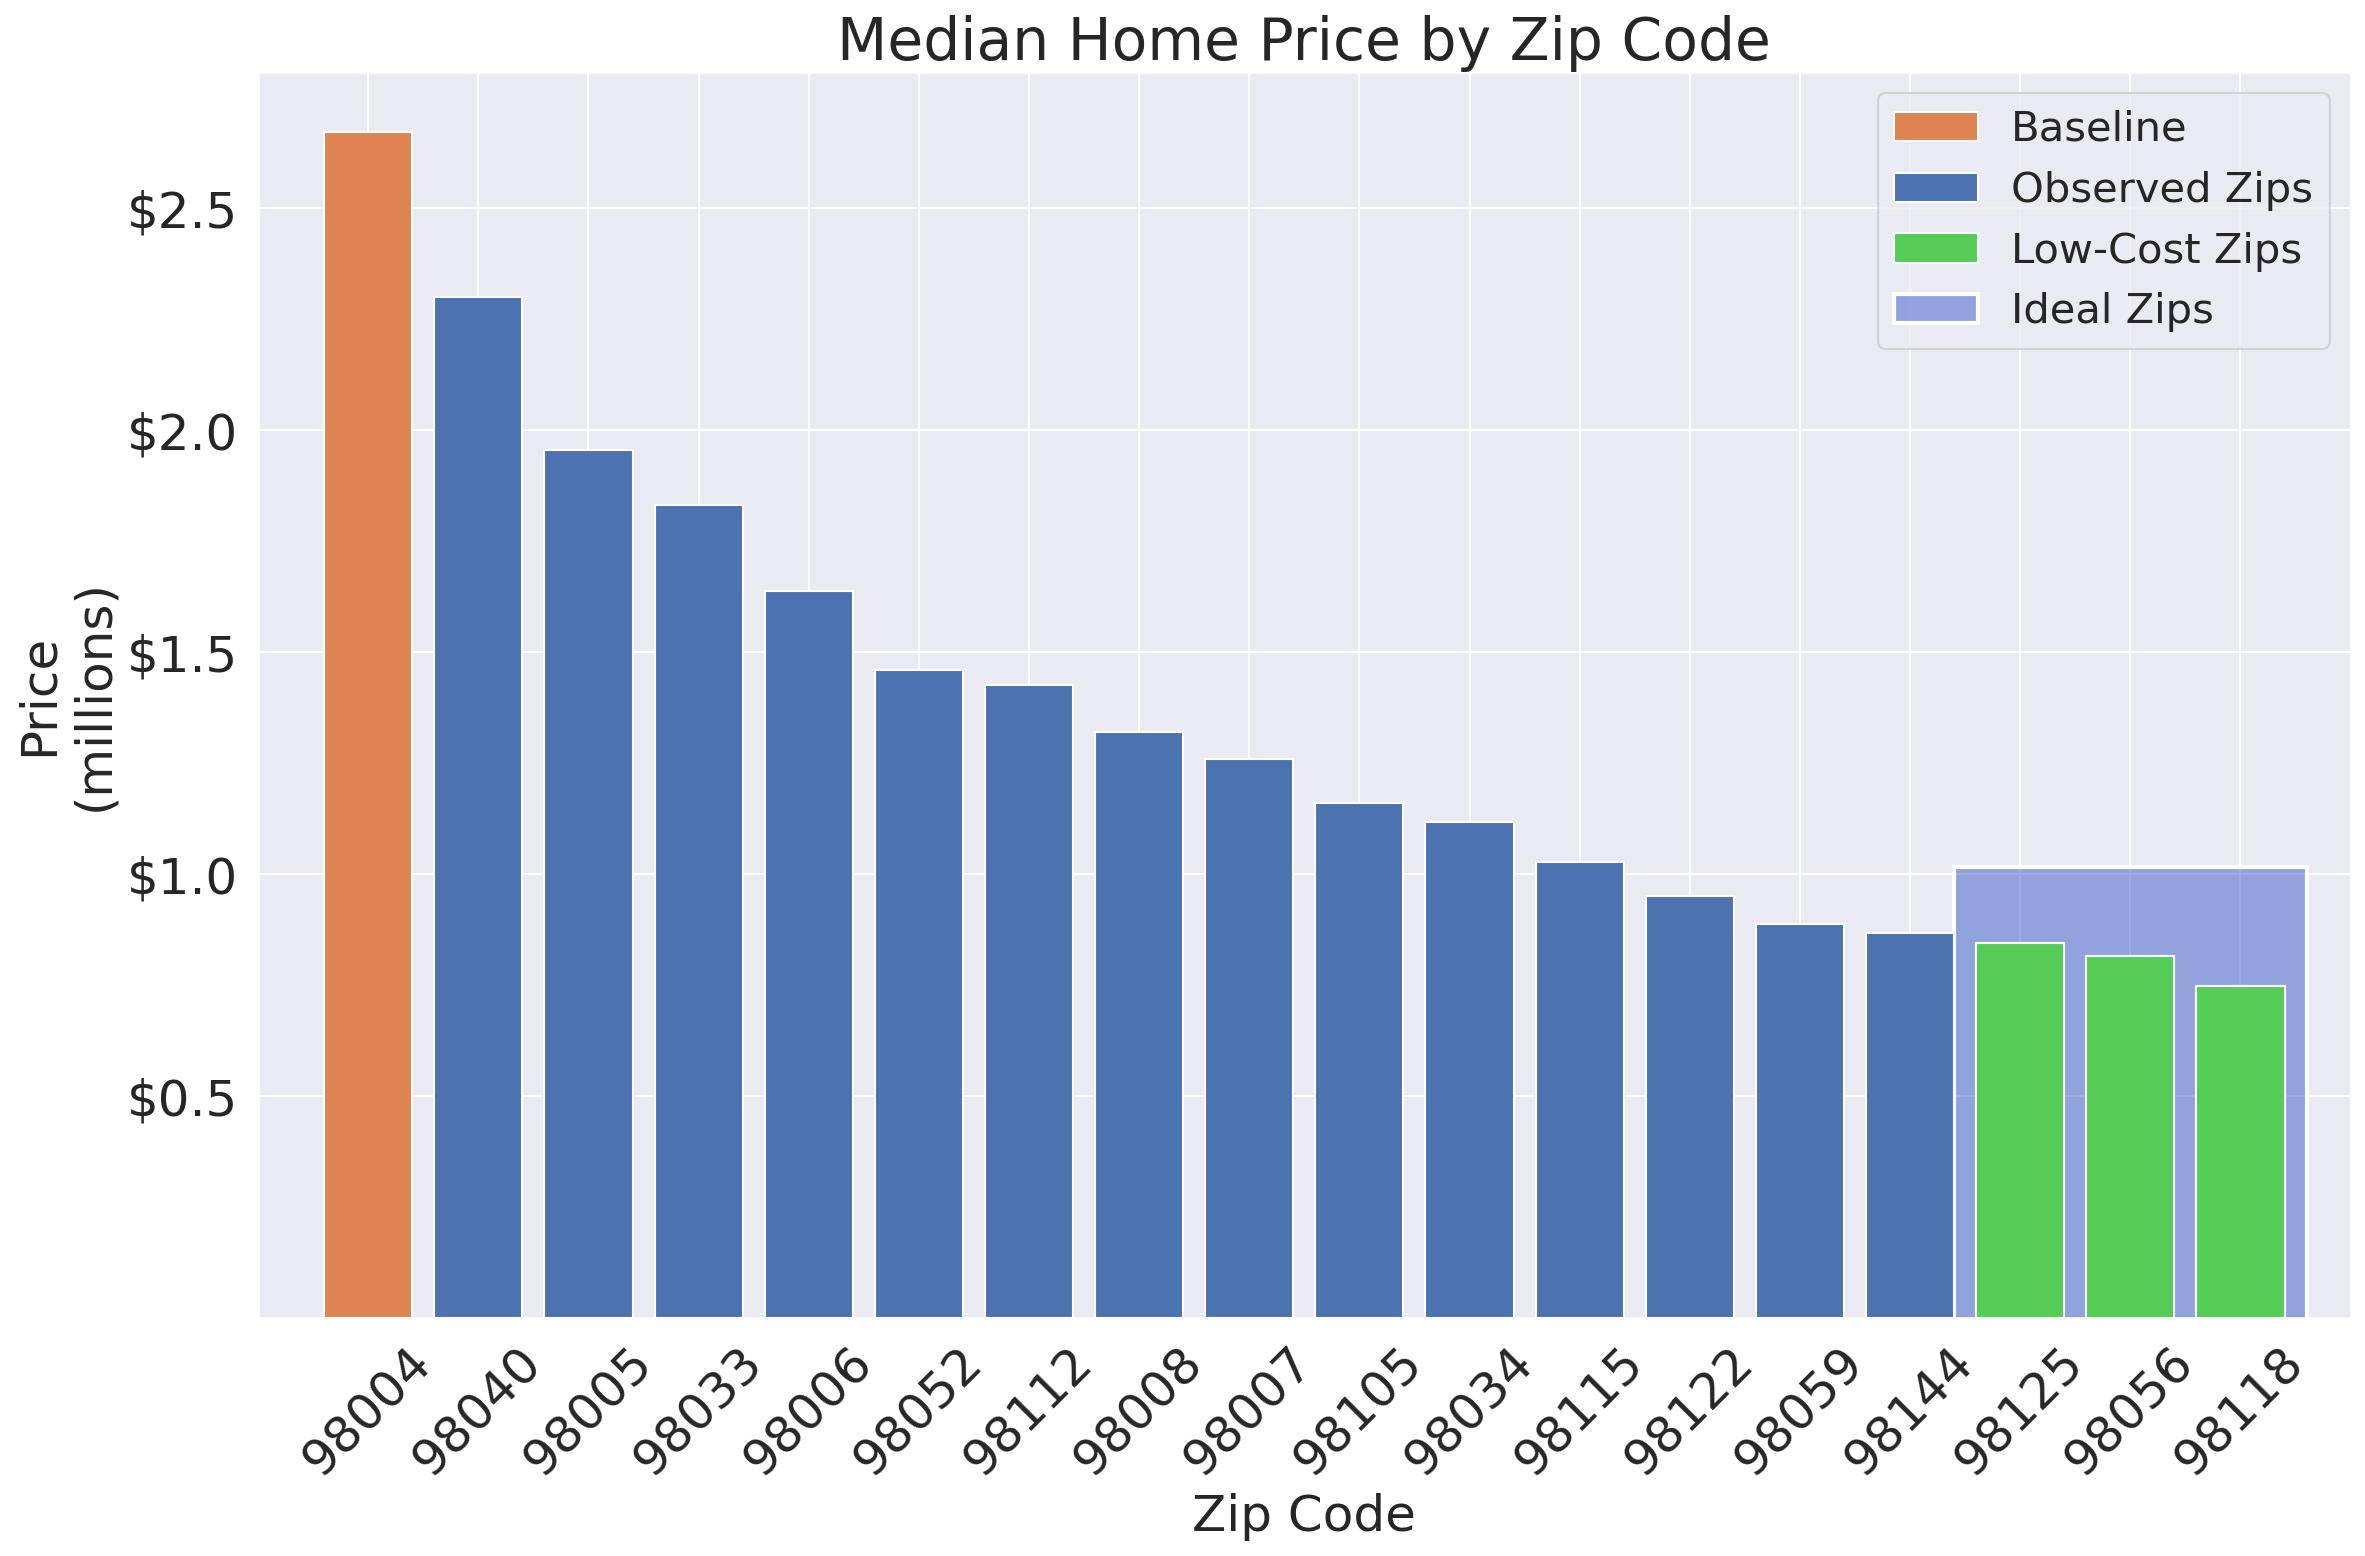

In [37]:
fig, ax = plt.subplots(figsize=(18,11),dpi=150)


y = nearby_zip_by_price_median['price']
x = nearby_zip_by_price_median['zip']

# create highlight box around last 3 bars
frame_offset = 500000
target_area = ax.add_patch(Rectangle((len(x)-3.6,-frame_offset),3.2,y[-3:].max()*1.2+frame_offset,
                        #edgecolor='#5c5',
                        #facecolor='#5c59',
                        facecolor='#46c8',
                        lw=2
                        ))

investigated_area = ax.bar(
    x=x,
    height=y,
    )


# highlight last 3 bars
target_zips = ax.bar(
    x=x[-3:],
    height=y[-3:],
    color="#55cc55"
)

baseline_zip = ax.bar(
    x=x[0],
    height=y[0]
)

ticks, ticklabels = ytick_convert(5,500000)
ax.set(
    yticks=ticks,
    yticklabels=ticklabels,
    ylim=[0,y.max()*1.05],
    xlim=[-1,len(x)]
)

plt.xticks(rotation=45,fontsize=24)
plt.yticks(fontsize=24)
plt.title("Median Home Price by Zip Code",fontsize=28)
plt.xlabel("Zip Code",fontsize=24)
plt.ylabel("Price\n(millions)",fontsize=24)
plt.legend(
    [
    baseline_zip,investigated_area  ,target_zips    ,target_area
    ],[
    'Baseline'  ,'Observed Zips'    ,'Low-Cost Zips','Ideal Zips'
    ],
    fontsize=20
    )
'';

Above, we've got the median home values of all of the zip codes within a 5-mile radius of 98004. We've highlighted the homes at the lowest cost that still fall within this range. These are homes that we expect will have the best access to the same amenities of the 98004 zip code at a much reduced cost <sub>_(less than half, on median!)_</sub>

In [38]:
nearby_homes_df[numeric_columns].shape

(8108, 12)

In [39]:
y = nearby_homes_df['price']

nearby_zip_homes = pd.get_dummies(
    nearby_homes_df['zip']
    ).drop(
        '98004',         # <= drop 98004, highest cost
        axis=1
    )



X = sm.add_constant(
    pd.concat(
        [nearby_homes_df[numeric_columns[1:]],nearby_zip_homes],
        axis=1
    )
)
#y = np.log(y)
nearby_zip_model = sm.OLS(y, X).fit()
print(nearby_zip_model.summary2())

                           Results: Ordinary least squares
Model:                    OLS                    Adj. R-squared:           0.689      
Dependent Variable:       price                  AIC:                      234058.0667
Date:                     2023-03-30 23:54       BIC:                      234261.0843
No. Observations:         8108                   Log-Likelihood:           -1.1700e+05
Df Model:                 28                     F-statistic:              642.9      
Df Residuals:             8079                   Prob (F-statistic):       0.00       
R-squared:                0.690                  Scale:                    2.0091e+11 
--------------------------------------------------------------------------------------
                      Coef.      Std.Err.     t     P>|t|      [0.025        0.975]   
--------------------------------------------------------------------------------------
const              1289792.2789 46060.0935  28.0024 0.0000  1199502.627

We are able to see a lot of significance in this model, but there are several assumptions that are being violated here. As well, there are several features that are not significant. We'll narrow down our model to look more specifically at features that we were able to investigate in the time provided, though it would be important to keep some of the other significant features in mind.

In [40]:
nearby_zip_homes = pd.get_dummies(
    nearby_homes_df['zip']
    ).drop(
        '98004',         # <= drop 98004, highest cost
        axis=1
    )

X = sm.add_constant(
    pd.concat(
        [
            nearby_homes_df[['bedrooms','bathrooms','sqft_living']],
            nearby_zip_homes
        ],
        axis=1
    )
)

nearby_zip_model = sm.OLS(y, X).fit()
print(nearby_zip_model.summary2())

                        Results: Ordinary least squares
Model:                  OLS                  Adj. R-squared:         0.683      
Dependent Variable:     price                AIC:                    234208.8586
Date:                   2023-03-30 23:54     BIC:                    234355.8713
No. Observations:       8108                 Log-Likelihood:         -1.1708e+05
Df Model:               20                   F-statistic:            874.4      
Df Residuals:           8087                 Prob (F-statistic):     0.00       
R-squared:              0.684                Scale:                  2.0488e+11 
--------------------------------------------------------------------------------
                Coef.      Std.Err.     t     P>|t|      [0.025        0.975]   
--------------------------------------------------------------------------------
const        1412708.8303 35282.0454  40.0404 0.0000  1343546.9407  1481870.7199
bedrooms      -81972.0660  6670.2822 -12.2891 0.0000 

We've improved some of our assumptions slightly and can see consistent significance across features.

We'll proceed with checking our assumptions against the data. Our Kurtosis indicates extreme tendency toward the center, or a lot of "peakiness" in our data. We'll investigate our assumptions in the coming cells.

In [41]:
prices_preds = nearby_zip_model.predict(X)
prices_resids = y - prices_preds

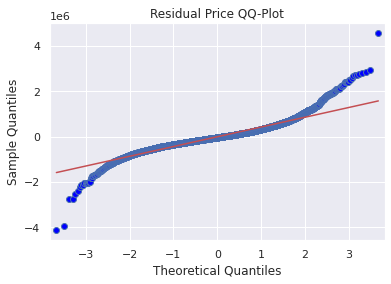

In [42]:
fig, ax = plt.subplots()
sm.qqplot(prices_resids, line='r', ax=ax);
ax.set(
    title="Residual Price QQ-Plot"
);

Our QQ Plot shows that there are some divergences at the extremeties, but the middle ground of our dataset seems to be fairly attached to the line.

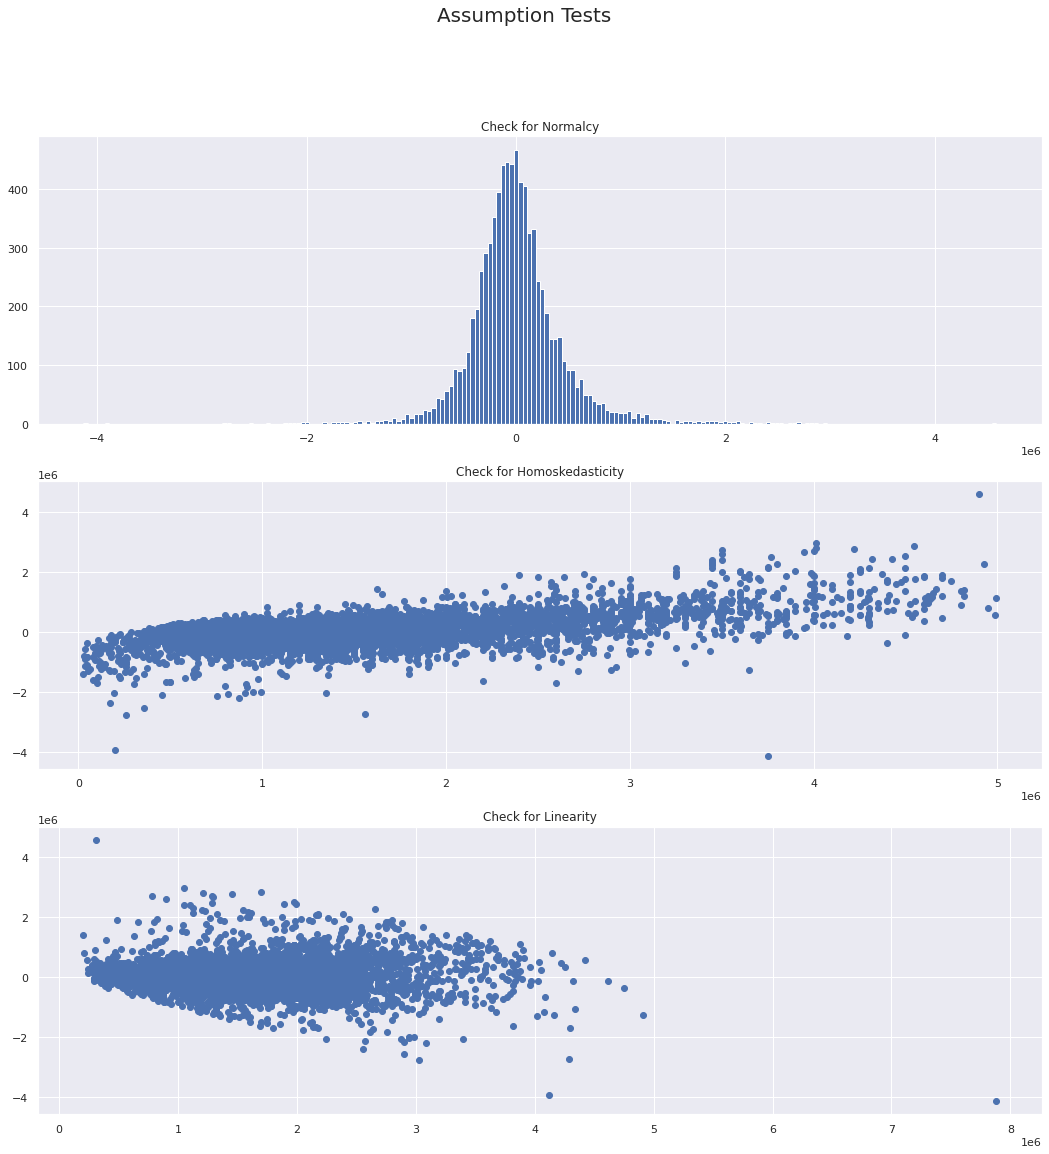

In [43]:
fig, ax = plt.subplots(3,1,figsize=(18,18))
ax[0].hist(prices_resids,bins='auto')
ax[0].set(
    title='Check for Normalcy',
)

ax[1].scatter(y,prices_resids)
ax[1].set(
    title='Check for Homoskedasticity',
)

ax[2].scatter(prices_preds,prices_resids)
ax[2].set(
    title='Check for Linearity',
)

fig.suptitle('Assumption Tests',fontsize=20)
'';

Our normalcy check shows a relatively strong normalcy of the data with few, albeit extreme, outliers.

Our check for homoskedasticity shows a mostly consistent variance in error.

Lastly, our check for linearity shows that there is a linear relation in a positive direction.

Our visual checks for assumptions seem to affirm the data presented in our model.

An interesting finding that we made, was that - given that all else is equal - the number of bedrooms in a house _**DECREASES**_ its value.  
Initially, this seems counterintuitive as houses with a lot of bedrooms tend to be larger. However, this stands to reason as two homes that have the same square footage will have a different amount of actual operating and daily living space based on the number of rooms in the house.

For instance, if a house is 1,000 square feet and has 2 bedrooms, the kitchen, living room, and other usable space would be higher compared to a 1,000 square foot home with 3 bedrooms, as the third bedroom would need to take some of this space up or the first two bedrooms would need to be smaller.

We can see this best in the CCPR plot in the figure below.

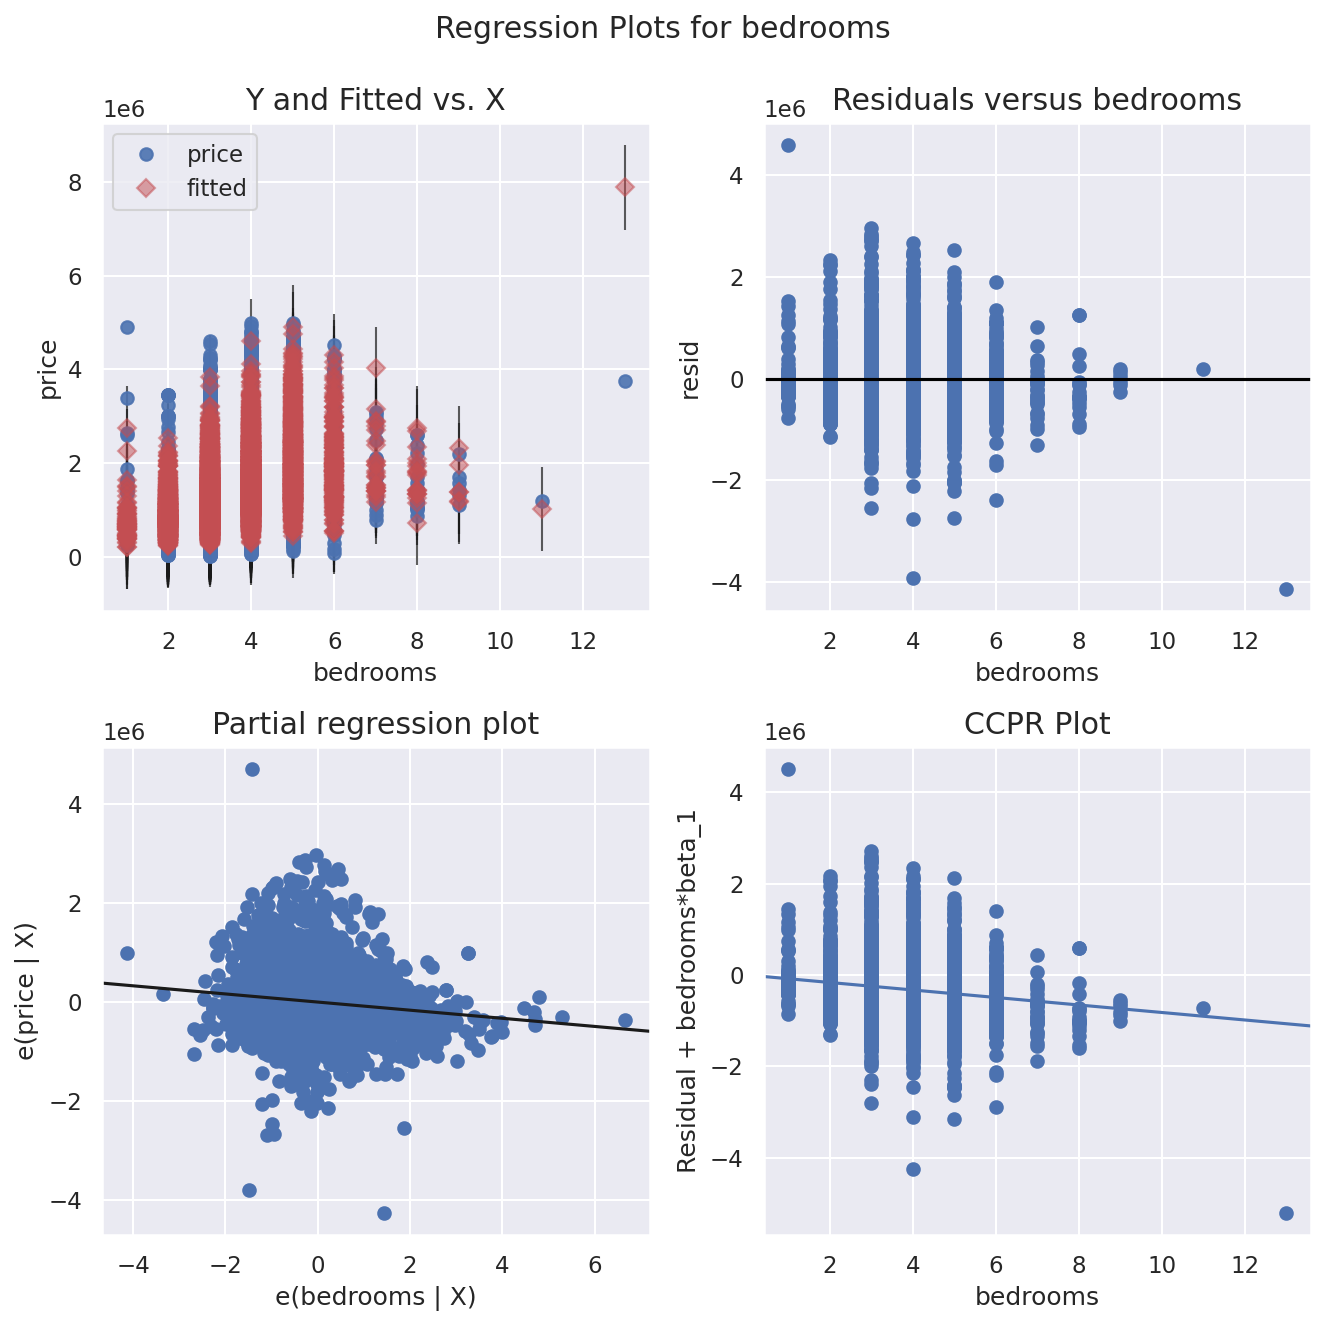

In [44]:
fig = plt.figure(figsize=(9,9),dpi=150)

nearby_zip_model
sm.graphics.plot_regress_exog(nearby_zip_model,
'bedrooms',
fig=fig)

'';

# The Final Model  
After narrowing our scope and selecting several significant features, our model is able to achieve an $r^2$ of $0.683$.

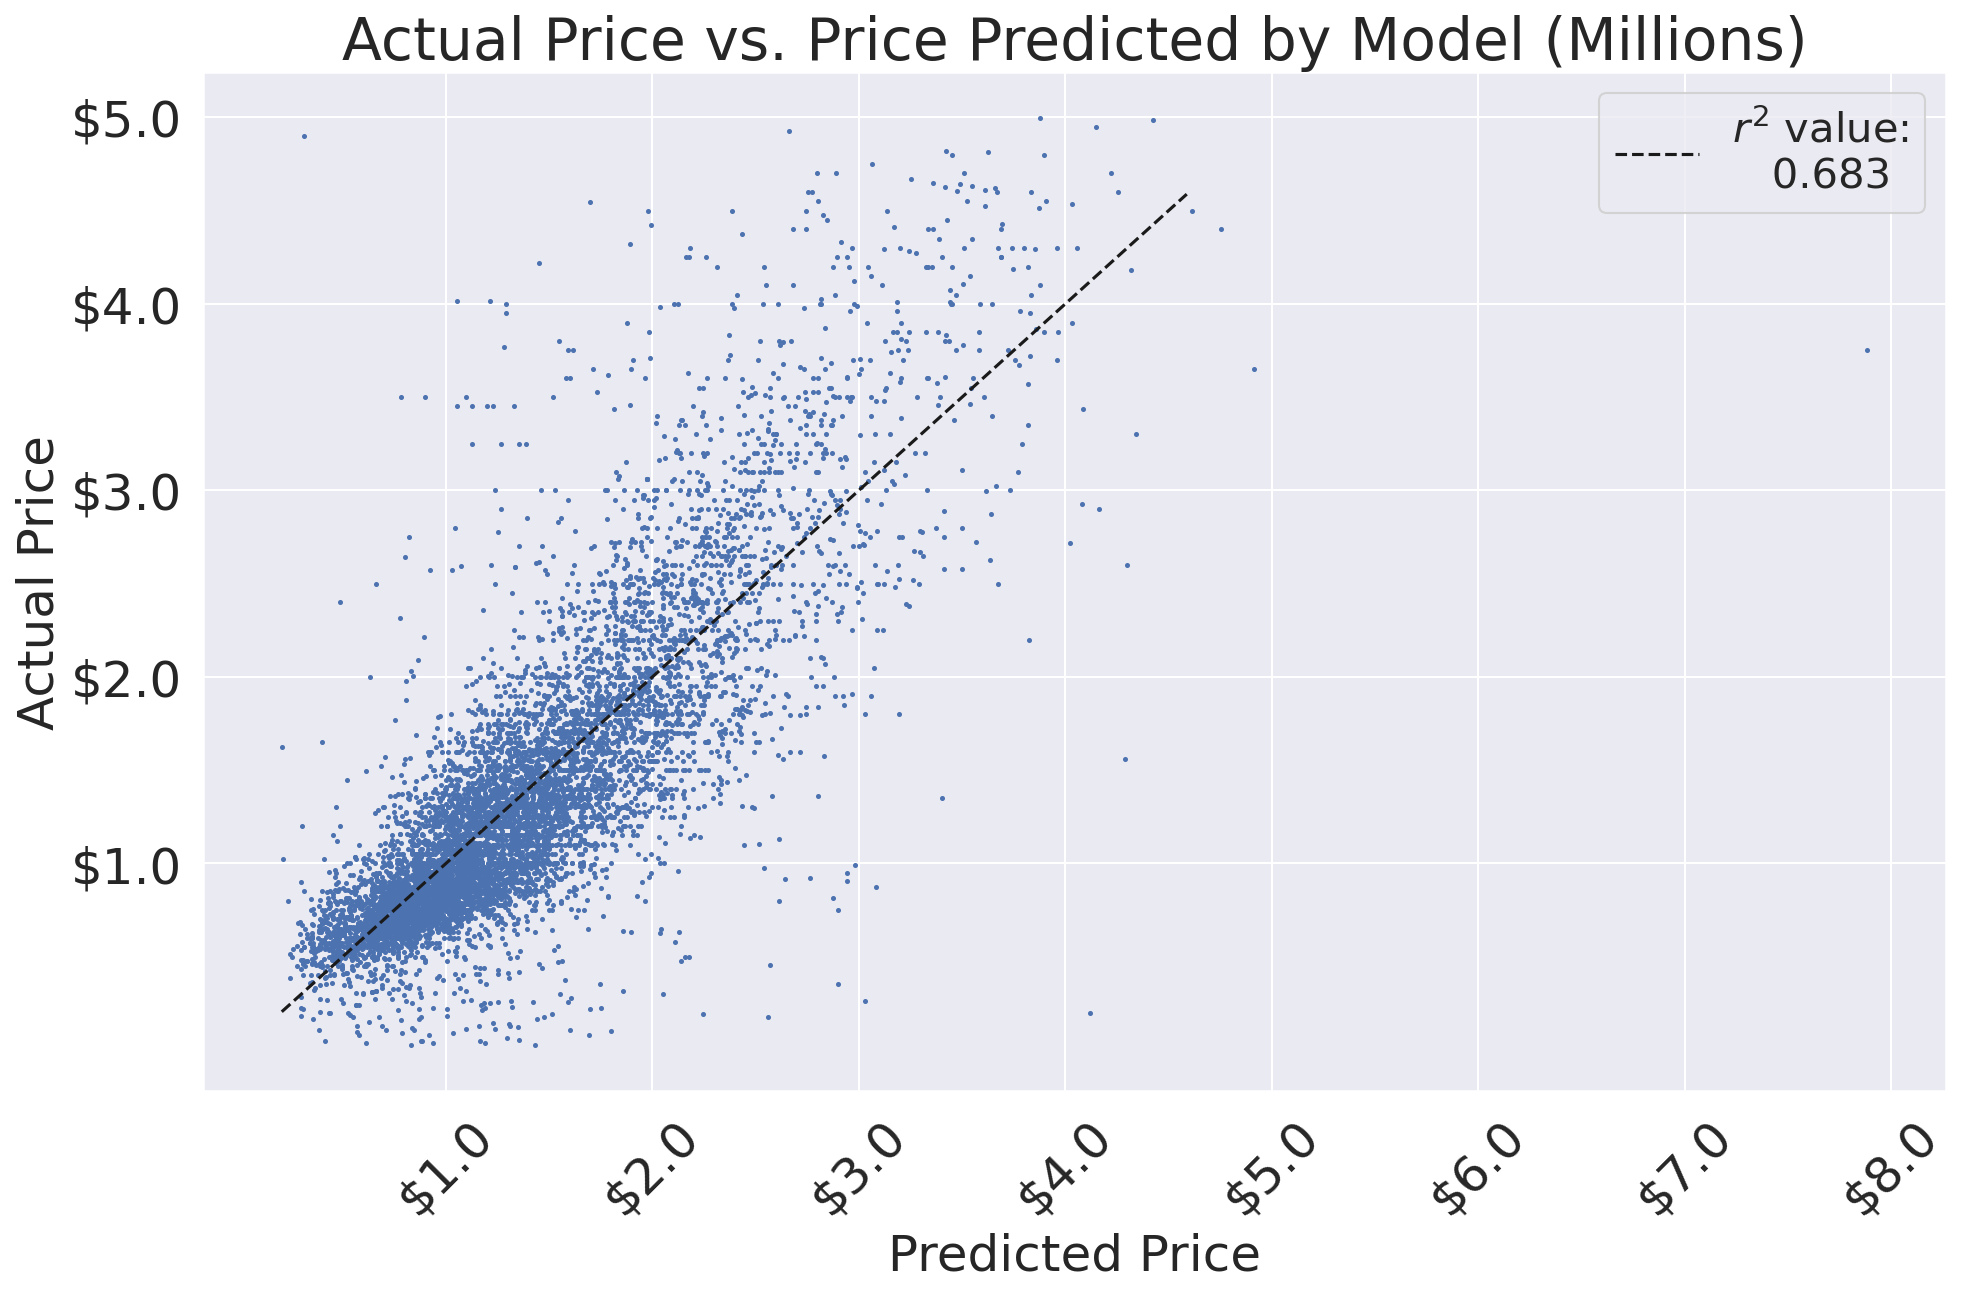

In [45]:
fig, ax = plt.subplots(figsize=(15,9), dpi=150)

r2 = nearby_zip_model.summary2().tables[0][3][0]



ax.scatter(prices_preds , y , s=2)
ax.plot([prices_preds.min(),prices_resids.max()],
    [prices_preds.min(),prices_resids.max()],
    'k--',
    label=f"""$r^2$ value:\n   {
        r2
        }"""
)


ticks, ticklabels = ytick_convert(5,1000000)
xticks, xticklabels = ytick_convert(8,1000000)
ax.set(
    xticks=xticks,
    xticklabels=xticklabels,
    yticks=ticks,
    yticklabels=ticklabels
)

plt.title('Actual Price vs. Price Predicted by Model (Millions)',fontsize=28)
plt.xlabel('Predicted Price',fontsize=24)
plt.ylabel('Actual Price',fontsize=24)
plt.rc('font',size=20)
plt.legend(fontsize=20)
plt.xticks(rotation=45,fontsize=24)
plt.yticks(fontsize=24)
'';

In [46]:
nearby_zip_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     874.4
Date:                Thu, 30 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:54:59   Log-Likelihood:            -1.1708e+05
No. Observations:                8108   AIC:                         2.342e+05
Df Residuals:                    8087   BIC:                         2.344e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.413e+06   3.53e+04     40.040      0.000    1.34e+06    1.48e+06
bedrooms    -8.197e+04   6670.282    -12.289      0.000    -9.5e+04   -6.89e+04
bathrooms    4.224e+04   8852.482      4.771      0.000    2.49e+04    5.96e+04
sqft_living   523.0724      8.941     58.504      0.000     505.546     540.599
98005        -5.59e+05   4.41e+04    -12.672      0.000   -6.45e+05   -4.72e+05
98006       -9.001e+05   3.45e+04    -26.069      0.000   -9.68e+05   -8.32e+05
98007       -9.407e+05   4.64e+04    -20.282      0.000   -1.03e+06    -8.5e+05
98008       -8.583e+05   3.66e+04    -23.440      0.000    -9.3e+05   -7.86e+05
98033       -5.689e+05   3.38e+04    -16.836      0.000   -6.35e+05   -5.03e+05
98034       -1.066e+06   3.35e+04    -31.825      0.000   -1.13e+06      -1e+06
98040       -4.968e+05   3.78e+04    -13.140      0.000   -5.71e+05   -4.23e+05
98052       -9.034e+05   3.42e+04    -26.433      0.000    -9.7e+05   -8.36e+05
98056       -1.359e+06   3.49e+04    -39.003      0.000   -1.43e+06   -1.29e+06
98059       -1.424e+06    3.4e+04    -41.845      0.000   -1.49e+06   -1.36e+06
98105        -9.53e+05   3.82e+04    -24.970      0.000   -1.03e+06   -8.78e+05
98112       -7.793e+05   3.87e+04    -20.139      0.000   -8.55e+05   -7.03e+05
98115       -1.048e+06   3.32e+04    -31.545      0.000   -1.11e+06   -9.83e+05
98118       -1.306e+06   3.44e+04    -37.979      0.000   -1.37e+06   -1.24e+06
98122       -1.054e+06   3.62e+04    -29.090      0.000   -1.13e+06   -9.83e+05
98125        -1.22e+06   3.55e+04    -34.388      0.000   -1.29e+06   -1.15e+06
98144        -1.15e+06   3.61e+04    -31.825      0.000   -1.22e+06   -1.08e+06
==============================================================================
Omnibus:                     1805.219   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22307.987
Skew:                           0.714   Prob(JB):                         0.00
Kurtosis:                      11.000   Cond. No.                     5.99e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.99e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Going Forward.

There are a lot of features that influence a home's price. We were even able to isolate some of these features and have a good jumping-off point for going through this analysis process and including these additional features. Provided enough time, we would likely be able to find additional features that might have a strong relation to the overall price and include them in the final model.  
Some features that seem to have potential influence would be things like the presence of a garage or potentially the number of bathrooms.

It may also be beneficial to look for things like local school ratings and other things of that nature.